<h1 align = "center" > 통신사 고객 이탈 데이터 분석 </h1>  
<h3 align = "right" > 201600177 문헌정보학과 이동헌 </h3>  



 이번 기말고사 대체 분석 프로젝트는 통신사 고객들의 이탈 관련 데이터를 분석하는 것이다. 해당 데이터에 대한 배경지식이 거의 없기에 우선 데이터 자체에 중심을 두고 분석을 진행할 것이다.   
 분석과정은 EDA를 한 후 실제로 이탈을 예측하는 모델을 작성해보고, 마지막으로 트리기반 모델들로 어떤 변수들이 이탈을 예측하는데 가장 큰 영향을 미치는가를 확인해 볼 것이다.
 

 <h3> EDA </h3>
 
 우선 데이터를 불러오는것으로 시작해 보자.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
telco = pd.read_csv('telco.csv')

In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Leave        3333 non-null   int64  
 1   MemberWeeks  3333 non-null   int64  
 2   NewContract  3333 non-null   int64  
 3   IsData       3333 non-null   int64  
 4   DataAmount   3333 non-null   float64
 5   Callcenter   3333 non-null   int64  
 6   CalMins      3333 non-null   float64
 7   CalCounts    3333 non-null   int64  
 8   MonthlyFee   3333 non-null   float64
 9   OverFee      3333 non-null   float64
 10  RoamingMin   3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [4]:
telco.head(10)

,Leave,MemberWeeks,NewContract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
5,0,118,0,0,0.00,0,223.4,98,57.0,11.03,6.3
6,0,121,1,1,2.03,3,218.2,88,87.3,17.43,7.5
7,0,147,0,0,0.00,0,157.0,79,36.0,5.16,7.1
8,0,117,1,0,0.19,1,184.5,97,63.9,17.58,8.7
9,0,141,0,1,3.02,0,258.6,84,93.2,11.10,11.2


In [5]:
corr = telco.corr()
corr.style.background_gradient(cmap='coolwarm')

,Leave,MemberWeeks,NewContract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
Leave,1.000000,0.016541,-0.259852,-0.102148,-0.087195,0.208750,0.205151,0.018459,0.072313,0.092812,0.068239
MemberWeeks,0.016541,1.000000,-0.024735,0.002918,0.014391,-0.003796,0.006216,0.038470,0.012581,-0.006749,0.009514
NewContract,-0.259852,-0.024735,1.000000,-0.006006,-0.019223,0.024522,-0.049396,-0.003755,-0.047291,-0.019105,-0.045871
IsData,-0.102148,0.002918,-0.006006,1.000000,0.945982,-0.017824,-0.001684,-0.011086,0.737490,0.021526,-0.001318
DataAmount,-0.087195,0.014391,-0.019223,0.945982,1.000000,-0.021723,0.003176,-0.007962,0.781660,0.019637,0.162746
Callcenter,0.208750,-0.003796,0.024522,-0.017824,-0.021723,1.000000,-0.013423,-0.018942,-0.028017,-0.012964,-0.009640
CalMins,0.205151,0.006216,-0.049396,-0.001684,0.003176,-0.013423,1.000000,0.006750,0.567968,0.007038,-0.010155
CalCounts,0.018459,0.038470,-0.003755,-0.011086,-0.007962,-0.018942,0.006750,1.000000,-0.007963,-0.021449,0.021565
MonthlyFee,0.072313,0.012581,-0.047291,0.737490,0.781660,-0.028017,0.567968,-0.007963,1.000000,0.281766,0.117433
OverFee,0.092812,-0.006749,-0.019105,0.021526,0.019637,-0.012964,0.007038,-0.021449,0.281766,1.000000,-0.011023


모든 변수별로 상관계수를 확인해본 결과이다. NewContract가 가장 큰 상관계수를 가지고 있는데 Leave를 예측할 때 가장 크게 사용될 것이라 생각된다. 후에 의사결정나무를 이용해 변수중요도를 확인한뒤 어느정도 일치하나 한번 비교해보자.

In [6]:
telco.describe()

,Leave,MemberWeeks,NewContract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.903090,0.276628,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,0.295879,0.447398,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


모든 변수들의 기술통계이다.  

그럼 이제 이탈에 따라 사람들이 이용량이 어떻게 바뀌는지 한번 확인해보자.

In [7]:
a = telco.groupby('Leave').mean().reset_index().melt(id_vars=['Leave'])
a

,Leave,variable,value
0,0,MemberWeeks,100.793684
1,1,MemberWeeks,102.664596
2,0,NewContract,0.934737
3,1,NewContract,0.716356
4,0,IsData,0.295439
5,1,IsData,0.165631
6,0,DataAmount,0.862151
7,1,DataAmount,0.546957
8,0,Callcenter,1.449825
9,1,Callcenter,2.229814


<AxesSubplot:xlabel='variable', ylabel='value'>

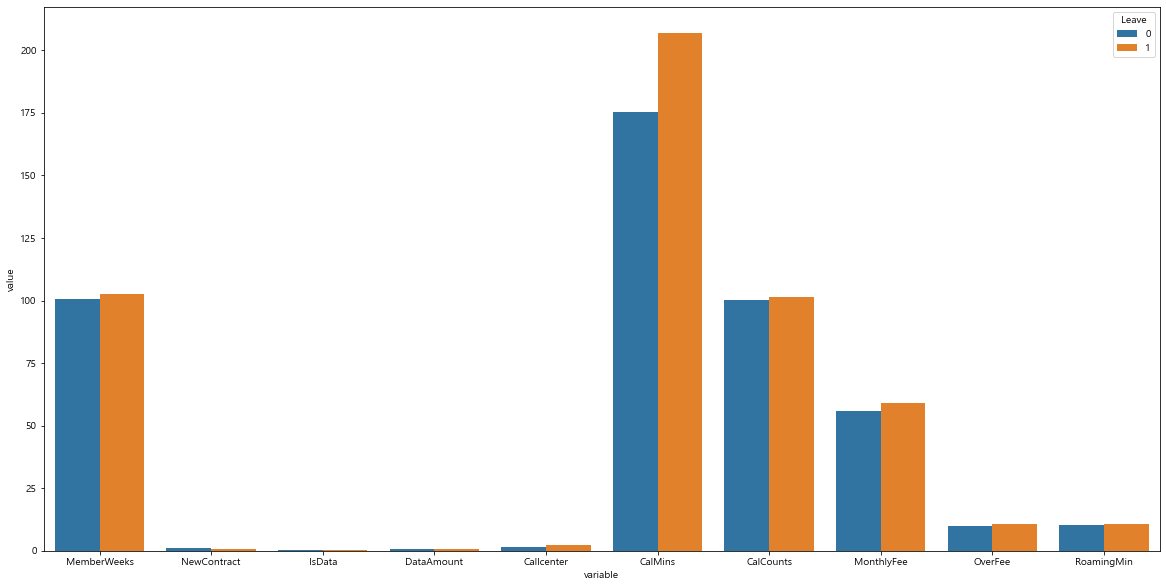

In [8]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fix, ax = plt.subplots(figsize = [20,10])

sns.barplot(x = a.variable, y = a.value, hue = a.Leave)

흥미로운점은 이탈자들이 이탈하지 않은 사람들보다 더의 모든 컬럼에서 더 많은 사용량을 보였다는 것이다. 

그 다음은 Leave와 가장 큰 상관계수를 보였던 NewContract와 교차테이블을 그려볼것이다.

In [9]:
pd.crosstab(telco.Leave, telco.NewContract)

NewContract,0,1
Leave,,
0,186,2664
1,137,346


가입 갱신 비율이 이탈여부에 따라 매우 크게 차이나는 것을 볼 수 있다. 그럼 반대로 가입갱신에 따라 변수들이 어떻게 바뀌는지도 알아보자.

In [10]:
a = telco.iloc[:,1:].groupby('NewContract').mean().reset_index().melt(id_vars=['NewContract'])
a

,NewContract,variable,value
0,0,MemberWeeks,104.071207
1,1,MemberWeeks,100.742193
2,0,IsData,0.284830
3,1,IsData,0.275748
4,0,DataAmount,0.891146
5,1,DataAmount,0.808462
6,0,Callcenter,1.464396
7,1,Callcenter,1.573422
8,0,CalMins,187.986997
9,1,CalMins,178.893887


<AxesSubplot:xlabel='variable', ylabel='value'>

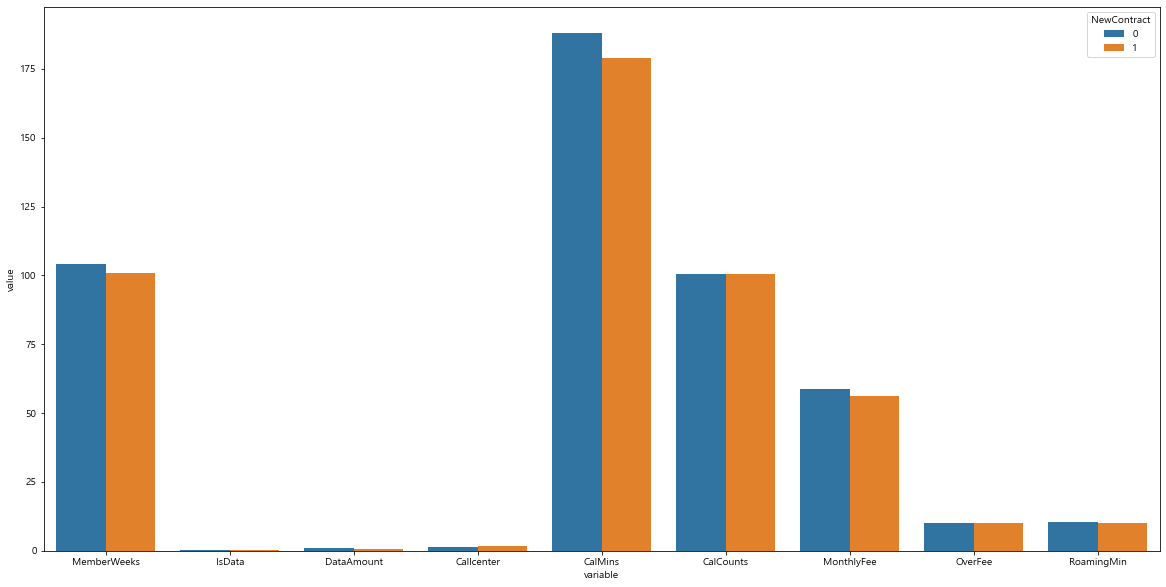

In [11]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fix, ax = plt.subplots(figsize = [20,10])

sns.barplot(x = a.variable, y = a.value, hue = a.NewContract)

이번에도 가입갱신을 하지 않는 쪽들이 사용량이 더 높은 것을 볼 수 있다.

그럼 이번엔 이탈여부를 제외한 모든 컬럼들의 히스토그램을 그려보자.

In [12]:
ex_leave = telco.iloc[:,1:]

In [13]:
ex_leave

,MemberWeeks,NewContract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...
3328,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


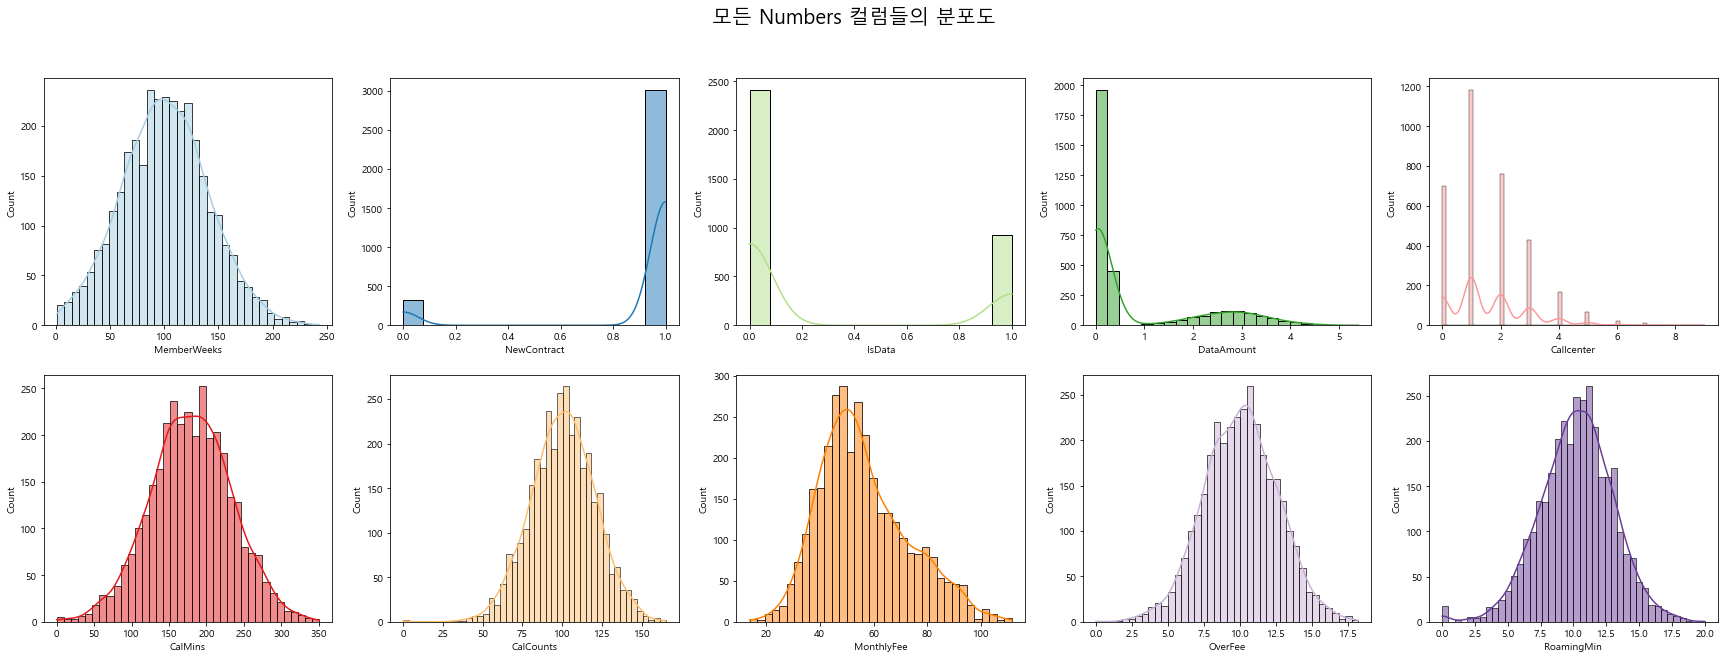

In [14]:
plt.rcParams['font.family'] = 'Malgun Gothic'
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = [30, 10])
color = sns.color_palette('Paired',10)
fig.suptitle('모든 Numbers 컬럼들의 분포도', fontsize = 20)

for i, column in enumerate(ex_leave.columns):
    sns.histplot(ex_leave[column], ax = axes[i // n_cols, i % n_cols], kde = True, color = color[i])
    


모든 float컬럼들은 정규분포를 어느정도 잘 따르고있는것을 확인할 수 있다. 

<h3> 예측모델 제작 </h3>

그럼이제 어느정도 데이터를 살표봤으니 실제로 Leave를 제외한 컬럼들을 바탕으로 Leave를 예측해보자.

In [27]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import time

In [28]:
X_train, X_test, y_train, y_test  = train_test_split(telco.iloc[:,1:], telco.iloc[:,0:1], stratify = telco.iloc[:,0:1], test_size = 0.2, random_state = 201600177)

우선 데이터를 train/test 셋으로 층화분할하였다.

In [17]:
def build_model(num_layers, num_nod, drop_rate, lr):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = len(X_train.columns)))
    model.add(keras.layers.BatchNormalization())
    for iterzz in range(0,num_layers):
        model.add(keras.layers.Dense(num_nod, activation = 'selu', kernel_initializer = 'lecun_normal'))
        model.add(keras.layers.AlphaDropout(rate = drop_rate))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = 'lecun_normal'))
    optimizer = keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9, nesterov = True)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return(model)

입력받은 hyperparameter로 뼈대를 model을 제작하는 사용자함수다.

In [18]:
def k_fold(X, y, num_layers, num_nod, drop_rate, lr, k):
    folds = StratifiedKFold(n_splits = k, shuffle = True, random_state = 201600177)
    acc = []
    for train_idx, val_idx in folds.split(X,y):
        X_cv_train = X.iloc[train_idx,]
        y_cv_train = y.iloc[train_idx,]
        X_cv_valid = X.iloc[val_idx,]
        y_cv_valid = y.iloc[val_idx,]
        model = None
        model = build_model(num_layers, num_nod, drop_rate, lr)
        callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 20)
        model.fit(X_cv_train, y_cv_train, epochs = 10000, callbacks = callback, batch_size = 128, verbose = 0)
        acc.append(model.evaluate(X_cv_valid, y_cv_valid, verbose = 0)[1])
    return(sum(acc)/len(acc))

만들어진 Model로 Train set에 대해 K-fold를 실행할 사용자 함수다.

In [19]:
def exapnd_grid(num_layers, num_nods, drop_rate, lr):
    return(np.array([(aa, ab, round(ac,5), round(ad,5)) for aa in num_layers for ab in num_nods for ac in drop_rate for ad in lr]))

그 다음 grid search를 위해 hyperparameter를 저장할 뼈대를 만들 사용자 함수를 지정했다.

In [20]:
grid = exapnd_grid(np.arange(1,4), np.arange(20,210,30), np.arange(0.05,0.2,0.05), [0.0001, 0.001, 0.01, 0.1])

앞의 사용자함수를 사용하여 레이어 갯수, 레이어당 노드 갯수, 노드 드랍 비율, 학습률을 바탕으로 grid를 지정했다.

In [21]:
def grid_search(X, y, gr, k):
    accl = []
    start = time.time()
    for i,g in enumerate(gr):
        accl.append(k_fold(X, y, int(g[0]), int(g[1]), g[2], g[3], 5))
        print(f'{i}/{len(gr)}')
    return([gr[accl.index(max(accl))], max(accl), time.time() - start])

앞에서 만들어진 grid로 실제로 train set에 대하여 k-fold를 진행하고 최적의 hyperparameter를 찾을 사용자함수이다.

In [22]:
result = grid_search(X_train, y_train, grid, 10)

0/336
1/336
2/336
3/336
4/336
5/336
6/336
7/336
8/336
9/336
10/336
11/336
12/336
13/336
14/336
15/336
16/336
17/336
18/336
19/336
20/336
21/336
22/336
23/336
24/336
25/336
26/336
27/336
28/336
29/336
30/336
31/336
32/336
33/336
34/336
35/336
36/336
37/336
38/336
39/336
40/336
41/336
42/336
43/336
44/336
45/336
46/336
47/336
48/336
49/336
50/336
51/336
52/336
53/336
54/336
55/336
56/336
57/336
58/336
59/336
60/336
61/336
62/336
63/336
64/336
65/336
66/336
67/336
68/336
69/336
70/336
71/336
72/336
73/336
74/336
75/336
76/336
77/336
78/336
79/336
80/336
81/336
82/336
83/336
84/336
85/336
86/336
87/336
88/336
89/336
90/336
91/336
92/336
93/336
94/336
95/336
96/336
97/336
98/336
99/336
100/336
101/336
102/336
103/336
104/336
105/336
106/336
107/336
108/336
109/336
110/336
111/336
112/336
113/336
114/336
115/336
116/336
117/336
118/336
119/336
120/336
121/336
122/336
123/336
124/336
125/336
126/336
127/336
128/336
129/336
130/336
131/336
132/336
133/336
134/336
135/336
136/336
137/336
138/33

In [23]:
result

[array([2.0e+00, 1.4e+02, 5.0e-02, 1.0e-01]),
 0.9174835443496704,
 27306.892758846283]

grid_search를 진행한 결과다. 해석하자면 히든 레이어는 2층, 노드는 140개, 드랍률은 0.05, 학습률은 0.1이 가장 효율적인 hyperparameter이며, 모든 fold에 대해 평균 정확률은 91.7%, grid search를 진행하는데 걸린 시간은 27306초, 7시간 반쯤된다.

In [24]:
tuned_model = build_model(int(result[0][0]), int(result[0][1]), result[0][2], result[0][3])
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 20)
tuned_model.fit(X_train, y_train, epochs = 10000, callbacks = callback, batch_size = 128)

Epoch 1/10000
21/21 [==============================] - 1s 7ms/step - loss: 0.7722 - accuracy: 0.5030
Epoch 2/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.6449 - accuracy: 0.6208
Epoch 3/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.5885 - accuracy: 0.6905
Epoch 4/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.5627 - accuracy: 0.7146
Epoch 5/10000
21/21 [==============================] - 0s 6ms/step - loss: 0.5224 - accuracy: 0.7543
Epoch 6/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.4964 - accuracy: 0.7794
Epoch 7/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.4810 - accuracy: 0.7937
Epoch 8/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.4553 - accuracy: 0.8027
Epoch 9/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.4424 - accuracy: 0.8211
Epoch 10/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.4299 - accura

그 후 찾은 최적의 hyperparameter로 새로 모델을 만든 후 train set에 다시 학습을 진행했다.

In [25]:
tuned_model.evaluate(X_test,y_test)

21/21 [==============================] - 0s 2ms/step - loss: 0.2452 - accuracy: 0.9205


[0.24515795707702637, 0.9205397367477417]

test set에 대해 실제 모델 performance를 확인해 본 결과다. 92.1퍼센트로 정확한 판단을 내린것을 확인할 수 있다.

<h3> 변수 중요도 </h3>

그럼 이탈을 효율적으로 예측할 수 있는 모델을 제작했으니, 이탈에 큰 영향을 끼치는 변수들을 찾아보자.  

Tree 기반 모델을 제작한 다음에 노드를 분리할 때 변수를 사용함으로써 증가/감소된 지니 불순도를 바탕으로 변수 중요도를 계산할 수 있다. 사이킷런의 Randomforest 모델을 이용해서 변수 중요도를 계산해보자.

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
forest = RandomForestClassifier(random_state=201600177)
forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=201600177)

In [101]:
importances = forest.feature_importances_

대표적인 트리기반 모델 중 하나인 Random forest를 사용하여 RF모델을 구축하는데 사용된 Feature들의 중요도를 가져왔다.  

이것으로 이해하기쉽게 그래프를 그려보자.

In [102]:
fi = pd.DataFrame({'feature' : X_train.columns, 'importances' : importances})

cor = telco.corr(method = 'pearson')
corabs = pd.DataFrame({'coefficient' : abs(cor.iloc[0,][1:].sort_values())}).reset_index()
corabs.rename(columns = {'index' : 'feature'}, inplace = True)

Text(0.5, 1.0, 'Pearson correlation coefficient: ordered by feature impotances')

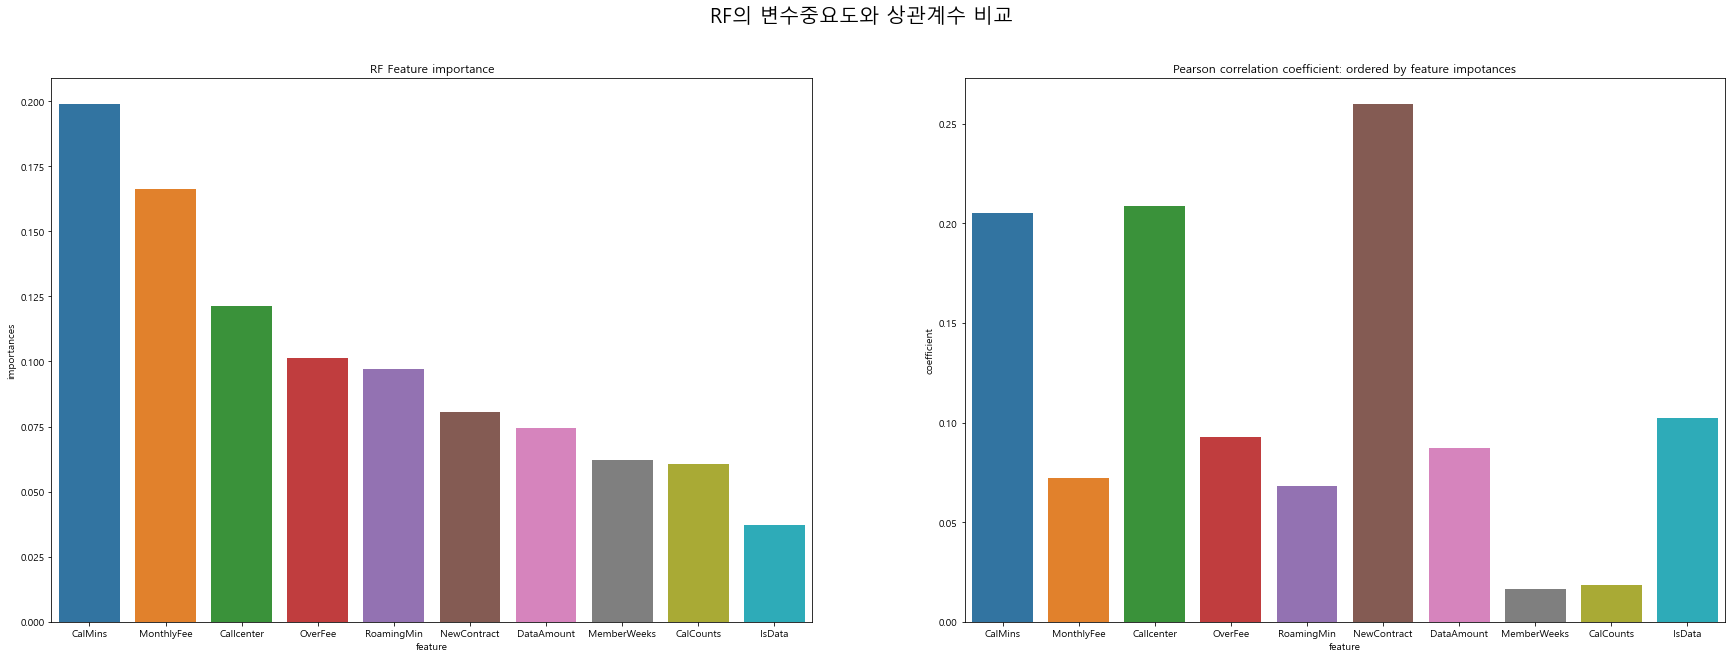

In [117]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, axes = plt.subplots(ncols = 2, figsize = [30, 10])
fig.suptitle('RF의 변수중요도와 상관계수 비교', fontsize = 20)

sns.barplot(data = fi, x = 'feature', y = 'importances', order = fi.sort_values('importances', ascending=False).feature, ax = axes[0])
axes[0].set_title('RF Feature importance')
sns.barplot(data = corabs, x = 'feature', y = 'coefficient', order = fi.sort_values('importances', ascending=False).feature, ax = axes[1])
axes[1].set_title('Pearson correlation coefficient: ordered by feature impotances')

의외다. 무작위적이라 해도 될정 도로 순서가 크게 차이나는 모습을 보인다. 상관계수에서 가장 컸기에 모델을 만드는데 가장 큰 영향을 줄 것이라 생각됐던 Newcontracts는 변수중요도에서 6위밖에 되지 않았다.

<h3> 결론 </h3>

 지금까지 통신사 고객 이탈 데이터를 분석해봤다. 이미 클린한 데이터를 사용했기에, 전처리의 불편함이 없었고 바로 EDA를 시작했다. EDA과정에서 상관계수를 확인했을 때 우리가 예측할 변수인 Leave와 가장 상관계수가 큰 Feature는 계약 갱신여부였기에 실제로 모델안에서도 이것이 가장 큰 영향을 끼칠 것이라 예측했다. 또한 데이터를 다양하게 조립해서 그래프를 그려보고 모든 변수들의 분포도 확인해 본 결과 모든 float feature들이 정규분포를 따르는 것도 확인했다. EDA를 마치고 실제로 Train/Test셋으로 나눈 후 Train set에 대해 K-fold cv를 이용해 hyperparameter를 튜닝한 후 최적화된 모델을 만들어 실제로 Test set에 대해 Performance를 측정한 결과 91퍼센트에 가깝게 정답을 맞췄다. 마지막으로 RF알고리즘을 이용하여 RF모델을 만들 때 사용된 변수들의 중요도를 확인해본 결과 앞에서 했던 예측과는 다르게 실제로는 사용량과 콜센터에 전화한 횟수가 계약 갱신 여부보다 더 큰 영향을 끼치며, 상관계수와 변수중요도 일치하지 않는 것을 보았다.
 
 
 솔직히 말해서 외국 통신사에 대해 아는게 거의없고 어느 통신사인지, 애초에 어느나라 통신사인지도 모르겠는 상황이라 찾아보는것도 힘들어서 이번 분석에서 나온 결과들이 얼마나 의미있는지는 모르겠다. 하지만 실제로 처음보는 데이터를 분석해서 의미있는 모델을 만들었고 어떤 변수가 중요한지 알아봄으로써 데이터 분석 역량을 기르는 좋은 기회가 된 것 같다.